# Using LasPy, Pandas and Datashader to visualize LIDAR data.

##### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
import imageio
from laspy.file import File
import datashader as ds
import datashader.transfer_functions as tf
from matplotlib import cm

##### Download sample data - begin with .las file

In [2]:
# Download sample data from: 'http://depot.ville.montreal.qc.ca/geomatique/lidar_aerien/2015/300-5046_2015.laz' and extract using lasZip
sample_data = '300-5046_2015.las'
export_path = 'export//'

### The basic load / visualization

##### Load LIDAR file with LasPy

In [3]:
inFile = File(sample_data, mode='r')
df = pd.DataFrame() 
df['X'] = inFile.X 
df['Y'] = inFile.Y 
df['Z'] = inFile.Z
df['class'] = inFile.classification
display(df)

,X,Y,Z,class
0,30001968,504699819,4163,1
1,30001825,504699992,4160,1
2,30001839,504699969,4157,2
3,30001853,504699946,4154,2
4,30001869,504699922,4158,2
5,30001883,504699899,4160,2
6,30001898,504699875,4162,1
7,30001913,504699851,4162,2
8,30001787,504699976,4160,2
9,30001803,504699950,4160,2


##### Plot the tile using datashader

C:\Users\tyler\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


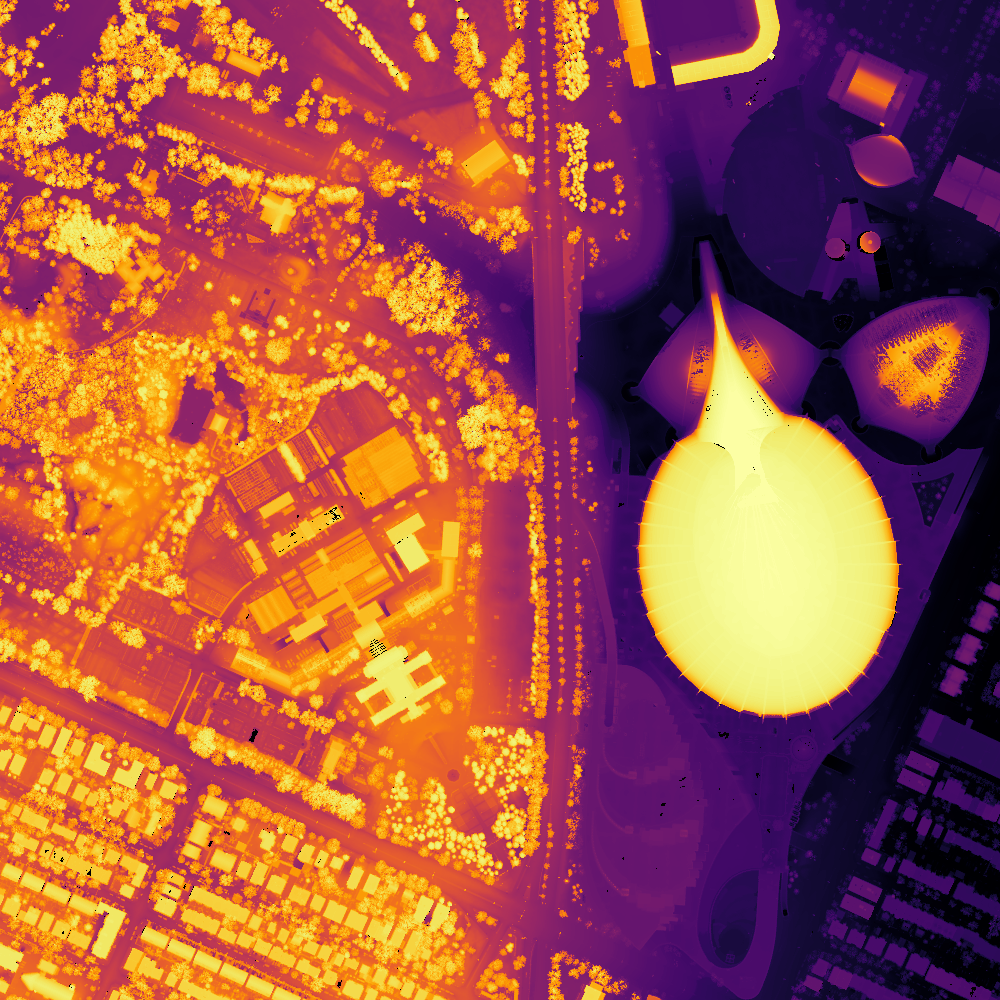

In [4]:
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(df, 'X', 'Y', ds.mean('Z'))
img = tf.shade(agg)#, cmap=['lightblue', 'darkblue'], how='log')
tf.set_background(tf.shade(agg, cmap=cm.inferno),"black")

### More complex operations

##### Seperate the different classes of pixel

C:\Users\tyler\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


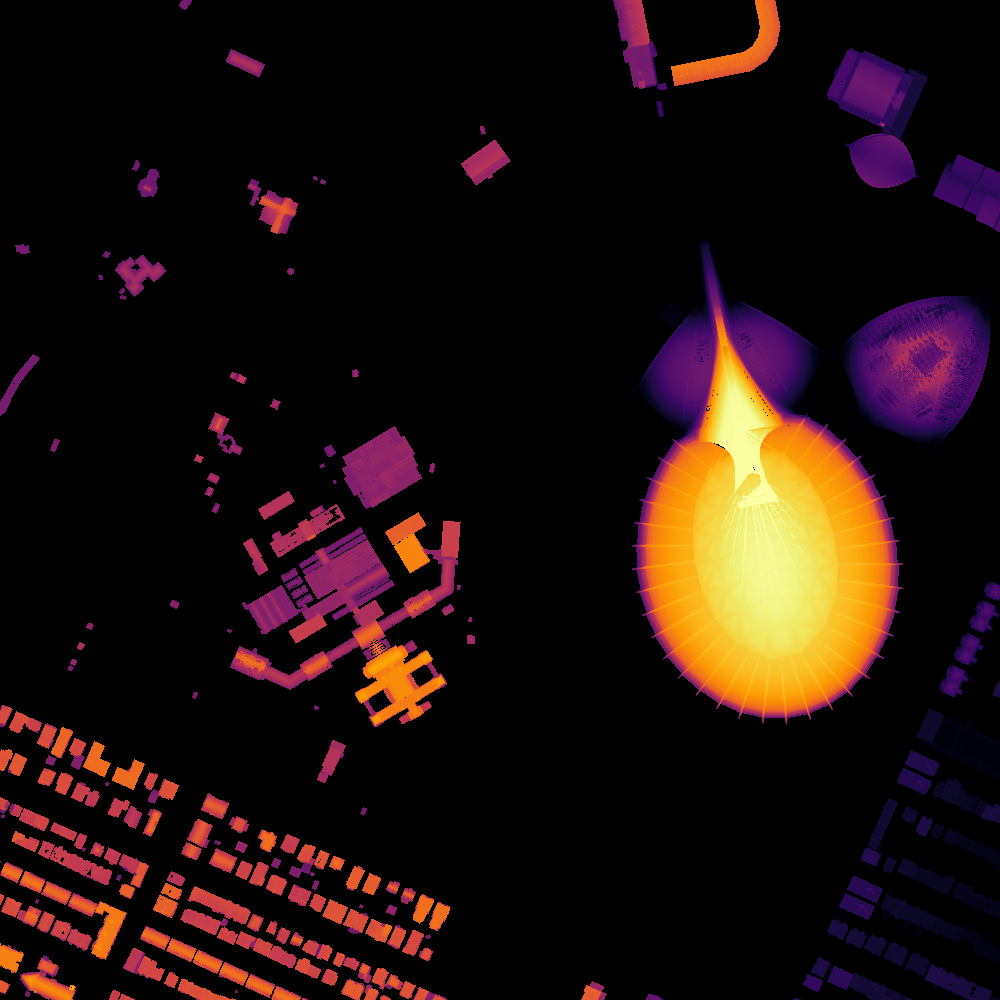

In [5]:
# Create a dataframe containing only the lidar voxels for buildings.
class_df = df.loc[df['class'] == 6]

# Visualize with datashader
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(class_df, 'X', 'Y', ds.mean('Z'))
img = tf.shade(agg)#, how='log')
tf.set_background(tf.shade(agg, cmap=cm.inferno),"black")

C:\Users\tyler\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


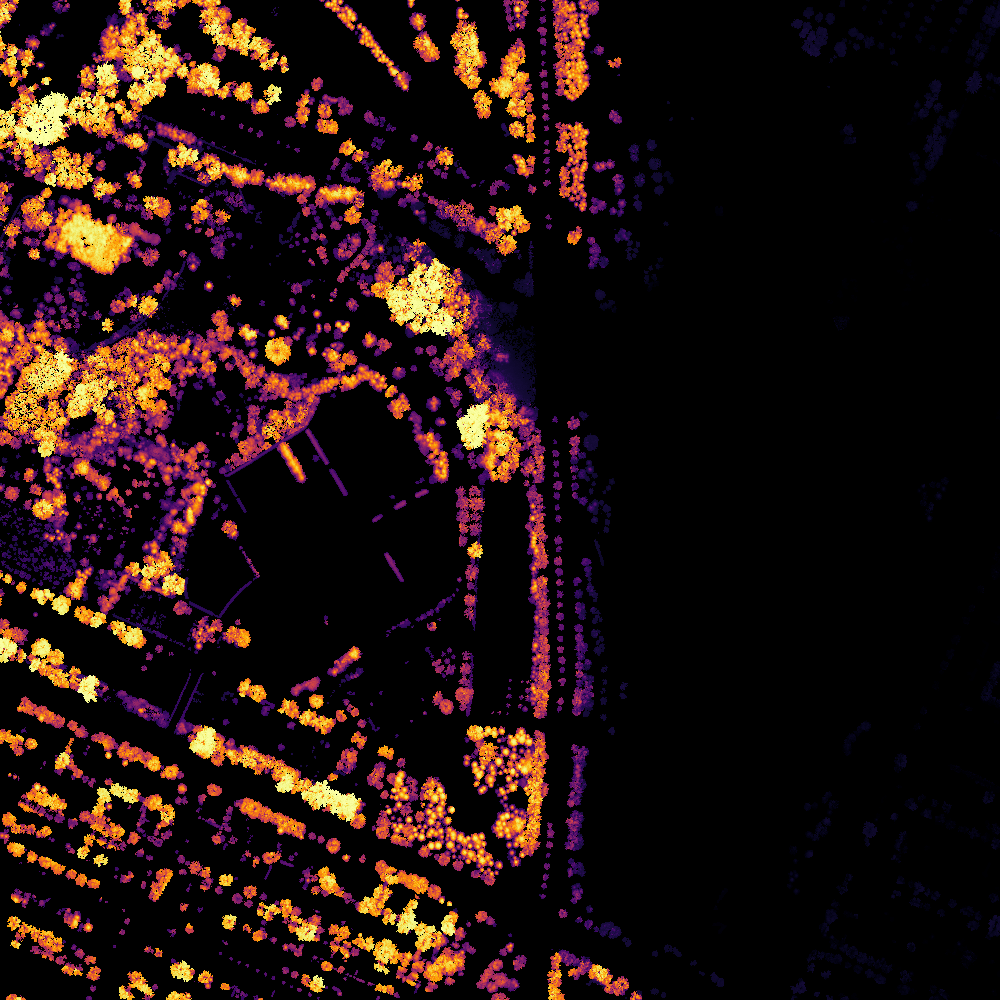

In [6]:
# Combine multiple classes of voxels that contain levels of vegetation
veg_df = df.loc[(df['class'] > 2) & (df['class'] < 6)]

# Visualize with datashader
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(veg_df, 'X', 'Y', ds.mean('Z'))
img = tf.shade(agg)#, how='log')
tf.set_background(tf.shade(agg, cmap=cm.inferno),"black")

##### Create a 3D surface visualization

In [ ]:
# Use entire image containing olympic stadium, etc.
X = df['X']
Y = df['Y']
Z = df['Z']

# Downsample x and y
ds_factor = 500
ds_x = X[::ds_factor] 
ds_y = Y[::ds_factor] 
ds_z = Z[::ds_factor] 

##### Export the gif
frames = []
identifier = 'bigO_tile_downsample_' + str(ds_factor) + 'x_surface_lidar'  

if not os.path.exists(export_path + identifier +'//'):
    os.makedirs(export_path + identifier +'//')

fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111, projection='3d')

# Plot the surface.
surf = ax.plot_trisurf(ds_x, ds_y, ds_z, cmap=cm.inferno,
                       linewidth=0, antialiased=False)

for angle in range(0, 360):
    ax.view_init(60, angle) # Higher angle than usually used of 30.
    ax.set_axis_off()

    # Draw the figure
    fig.canvas.draw()

    # Convert to numpy array, and append to list
    np_fig = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    np_fig = np_fig.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(np_fig)

imageio.mimsave(export_path + identifier + '.gif', frames)

C:\Users\tyler\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
